# Generate beautiful lyrics for your next hit!


## Data cleaning and encoding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from torch.utils.data import Dataset, DataLoader
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Loading positive dataset.
posdf = pd.read_csv('/content/drive/MyDrive/NLP_Song_Data/positive_lyrics.csv')

In [6]:
# Uncomment this line to reduce size of dataset for faster training - positive dataset.
posdf = posdf.head(300)
posdf.head()

,Artist,Lyrics,Sentiment
0,Taylor Swift Lyrics,i said remember this moment \n in the back of ...,Positive
1,Taylor Swift Lyrics,knew he was a killer first time that i saw him...,Positive
2,Taylor Swift Lyrics,i think you fell off of your cloud today \n yo...,Positive
3,Taylor Swift Lyrics,your beautiful eyes \n stare right into my eye...,Positive
4,Taylor Swift Lyrics,guess mine is not the first heart broken \n my...,Positive


In [7]:
#Loading negative dataset
negdf = pd.read_csv('/content/drive/MyDrive/NLP_Song_Data/negative_lyrics.csv')

In [8]:
# Uncomment this line to reduce size of dataset for faster training - negative dataset.
negdf = negdf.head(300)
negdf.head()

,Artist,Lyrics,Sentiment
0,Taylor Swift Lyrics,let me know how's it feel \n to be under my sk...,Negative
1,Taylor Swift Lyrics,i can't believe you did it again \n walked by ...,Negative
2,Taylor Swift Lyrics,taylor swift \n âcause baby now we've got bad ...,Negative
3,Taylor Swift Lyrics,here in my mind the sky looks the same \n on e...,Negative
4,Taylor Swift Lyrics,throwing pennies at the fountain \n when you'...,Negative


In [9]:
def replacenewline(dataframe):
    '''
    Cleans up lyrics by changing \n to 'newline' to help tokenizer and removes unnecessary junk terms.
    param dataframe: datadframe to remove from.
    '''
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"\n", "newline", regex=True)
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"urlembedcopy", "", regex=True)
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"urlcopyembedcopy", "", regex=True)
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"roamembedshare", "", regex=True)

In [10]:
replacenewline(posdf)
replacenewline(negdf)

In [11]:
# get combined lyrics in one list.
combined_lyrics_pos = posdf['Lyrics'].str.cat(sep = ' newline ')
combined_lyrics_neg = negdf['Lyrics'].str.cat(sep = ' newline ')

In [12]:
def getcleantoks(temp_tokens):
    '''
    Removes empty tokens from list.
    '''
    tokens = []
    for tok in temp_tokens:
        if len(tok) > 0:
            tokens.append(tok)
    return tokens

In [13]:
pos_tokens = getcleantoks(combined_lyrics_pos.split(" "))
neg_tokens = getcleantoks(combined_lyrics_neg.split(" "))

In [14]:
pos_tokens[:10]

['i',
 'said',
 'remember',
 'this',
 'moment',
 'newline',
 'in',
 'the',
 'back',
 'of']

In [15]:
neg_tokens[:10]

['let', 'me', 'know', "how's", 'it', 'feel', 'newline', 'to', 'be', 'under']

In [16]:
#pos_tokens = pos_tokens[0:20000]

In [17]:
#Number of positive tokens
len(pos_tokens)

113126

In [18]:
# Number of negative tokens
len(neg_tokens)

125089

In [19]:
#label_list --- last word of the training_list of tokens,
#it will be used to predict the next possible words once the model is trained on the training_list

In [20]:
def generateTrainingSet(tokens, n):
    '''
    converts the token list into dataset with x values bwing wi to wk-1 and y being wk.
    param tokens: list og tokens
    param n: the size of n gram representation.
    '''
    training_list = []
    label_list = []
    for i in range(len(tokens)):
        if i + n > len(tokens) - 1:
            break
        training_list.append(tokens[i:i+n])
        label_list.append(tokens[i+n])

    return np.asarray(training_list), np.asarray(label_list)

In [21]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def generateTrainingSet(tokens, n):
    training_list = []
    label_list = []
    for i in range(len(tokens)):
        if i + n >= len(tokens):
            break
        training_list.append(tokens[i:i+n])
        label_list.append(tokens[i+n])

    # Ensure each sequence in training_list is non-empty
    if any(len(seq) != n for seq in training_list):
        print("Error: Not all sequences have length", n)

    # Pad the sequences
    training_list = pad_sequences(training_list, maxlen=n, padding='post', dtype='int32')

    return np.asarray(training_list), np.asarray(label_list)


In [22]:
# Encode positive data.
tokenizer_positive = Tokenizer()
tokenizer_positive.fit_on_texts(pos_tokens)
encoded_pos = tokenizer_positive.texts_to_sequences(pos_tokens)

In [23]:
tokenizer_positive.word_index["newline"]
tokenizer_positive.index_word[1]

'newline'

In [24]:
# Encode negative data.
tokenizer_negative = Tokenizer()
tokenizer_negative.fit_on_texts(neg_tokens)
encoded_neg = tokenizer_negative.texts_to_sequences(neg_tokens)

In [25]:
len(encoded_neg)
tokenizer_negative.word_index["newline"]
tokenizer_negative.index_word[1]

'newline'

In [26]:
posX, posY = generateTrainingSet(encoded_pos, 8)
negX, negY = generateTrainingSet(encoded_neg, 8)

In [27]:
posY.shape

(113118, 1)

In [28]:
posX.shape

(113118, 8, 1)

In [29]:
posX = posX.reshape((len(posX),8))
posY = posY.reshape((len(posY), ))

In [30]:
posX

array([[  3, 109, 182, ...,   1,  11,   4],
       [109, 182,  25, ...,  11,   4,  60],
       [182,  25, 604, ...,   4,  60,  17],
       ...,
       [  1, 111,  75, ...,   1, 111,  75],
       [111,  75,  18, ..., 111,  75,  18],
       [ 75,  18, 316, ...,  75,  18, 316]], dtype=int32)

In [31]:
posY

array([ 60,  17,  10, ...,  18, 316,  40])

In [32]:
posY.shape

(113118,)

In [33]:
negX = negX.reshape((len(negX),8))
negY = negY.reshape((len(negY), ))

# Creating models

In [34]:
class LSTMModel(nn.Module):
    '''
    LSTM model with embedding layer, lstm layer and fully connected layer.
    '''

    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_size = 200
        self.embed = nn.Embedding(vocab_size, self.embedding_size)
        self.lstmlayer = nn.LSTM(input_size = self.embedding_size, hidden_size = 128, num_layers = 2, dropout = 0.1)
        self.ln1 = nn.Linear(128, vocab_size)
        #self.ln2 = nn.Linear(256, vocab_size)

    def forward(self, x):
        layer1 = self.embed(x.t())
        layer2, junk = self.lstmlayer(layer1)
        layer3 = self.ln1(layer2[-1])
        #layer4 = self.ln2(layer3[-1])
        return layer3


In [35]:
class RNNModel(nn.Module):
    '''
    RNN model with embedding layer, lstm layer and fully connected layer.
    '''

    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_size = 200
        self.embed = nn.Embedding(vocab_size, self.embedding_size)
        self.lstmlayer = nn.RNN(input_size = self.embedding_size, hidden_size = 128, num_layers = 2, dropout = 0.1)
        self.ln1 = nn.Linear(128, vocab_size)
        #self.ln2 = nn.Linear(256, vocab_size)

    def forward(self, x):
        layer1 = self.embed(x.t())
        layer2, junk = self.lstmlayer(layer1)
        layer3 = self.ln1(layer2[-1])
        #layer4 = self.ln2(layer3[-1])
        return layer3


In [36]:
posX_train = torch.tensor(posX, dtype=torch.long)
posY_train = torch.tensor(posY, dtype=torch.long)

In [37]:
posX_train.shape

torch.Size([113118, 8])

In [38]:
negX_train = torch.tensor(negX, dtype=torch.long)
negY_train = torch.tensor(negY, dtype=torch.long)

In [39]:
len(set(pos_tokens))

4760

In [40]:
pos_model = LSTMModel(len(set(pos_tokens)) + 1)
neg_model = LSTMModel(len(set(neg_tokens)) + 1)

In [41]:
def getdataloader(x, y):
    '''
    Dataloader from torch to feed data one by one.
    '''
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y,), batch_size = 128)


In [42]:
pos_train_dload = getdataloader(posX_train, posY_train)
neg_train_dload = getdataloader(negX_train, negY_train)

In [43]:
# Optimizers and learning rate
learning_rate = 0.001
optimpos = torch.optim.Adam(pos_model.parameters(), lr = learning_rate)
optimneg = torch.optim.Adam(neg_model.parameters(), lr = learning_rate)

# Train the models

In [44]:
def train(model, max_epochs, dataloader, opt):
    '''
    Trains the torch network
    '''
    for epoch in range(max_epochs):
        start = time.time()
        print("epoch ", epoch,"/", max_epochs, end = " ")
        model.train()
        cel = 0
        crossentropyloss = torch.nn.CrossEntropyLoss()
        counter = 9
        temploss = 0.0
        for i, (x, y) in enumerate(dataloader):
            pred_y = model(x)
            L = crossentropyloss(pred_y, y)
            opt.zero_grad()
            counter = 0
            for k in range(5):
                counter += 1
            L.backward()
            counter -= 1
            opt.step()
            counter += 1
            temploss+= L.item()/len(dataloader)
        endtime = time.time() - start
        print('loss={:.5f}    time={:.1f}s'.format(temploss, endtime))


In [45]:
# training positive model with lstm
train(pos_model, 3, pos_train_dload, optimpos)

epoch  0 / 3 loss=5.65082    time=41.0s
epoch  1 / 3 loss=5.03237    time=45.8s
epoch  2 / 3 loss=4.71230    time=48.3s


In [46]:
#training negative model with lstm
train(neg_model, 3, neg_train_dload, optimneg)

epoch  0 / 3 loss=5.77175    time=55.3s
epoch  1 / 3 loss=5.14538    time=55.2s
epoch  2 / 3 loss=4.81936    time=49.3s


In [47]:
posX_train.shape

torch.Size([113118, 8])

In [48]:
posY_train.shape

torch.Size([113118])

In [49]:
pos_rnn = RNNModel(len(set(pos_tokens)) + 1)
neg_rnn = RNNModel(len(set(neg_tokens)) + 1)

In [50]:
optimposrnn = torch.optim.Adam(pos_rnn.parameters(), lr = learning_rate)
optimnegrnn = torch.optim.Adam(neg_rnn.parameters(), lr = learning_rate)

In [51]:
# training positive model with rnns
train(pos_rnn, 3, pos_train_dload, optimposrnn)

epoch  0 / 3 loss=5.53188    time=24.8s
epoch  1 / 3 loss=4.80819    time=24.9s
epoch  2 / 3 loss=4.42595    time=28.5s


In [52]:
# training negative model with rnns
train(neg_rnn, 3, neg_train_dload, optimnegrnn)

epoch  0 / 3 loss=5.58264    time=31.7s
epoch  1 / 3 loss=4.83430    time=33.7s
epoch  2 / 3 loss=4.43247    time=32.6s


## Generating songs

In [53]:
def getseeds(dataset, num):
    '''
    generate random seeds to generate songs with.
    param num - number of seeds to sample
    '''
    seeds = []
    for i in range(num):
        temp = []
        seed = getcleantoks(dataset['Lyrics'].sample().values[0].split(" "))[0:8]
        seeds.append(seed)

    return seeds

pos_seeds = getseeds(posdf, 10)
neg_seeds = getseeds(negdf, 10)

In [54]:
def prob_sample(arr):
    '''
    Sample the predicted output to pick next sequence based on probability distribution and variance.
    '''
    var = 0.8
    probs = np.log(np.asarray(arr).astype('float64'))/var
    return np.argmax(np.random.multinomial(1,np.exp(probs)/np.sum(np.exp(probs)),1))


In [55]:
def prob_sample(arr):
    '''
    Sample the predicted output to pick next sequence based on probability distribution and variance.
    '''
    var = 0.8
    probs = np.log(np.asarray(arr).astype('float64'))/var
    probs = probs - np.max(probs)
    probs = np.exp(probs)/np.sum(np.exp(probs))
    return np.argmax(np.random.multinomial(1,probs,1))

In [56]:
def generatesongs(seeds, token, model, maxiter, dims):
    '''
    generates songs by encoding seeds, passing through model and generating maxiter amount of sequences.
    '''
    songs = []
    counter = 0
    for seed in seeds:
        sentences = []
        start = seed
        next_seed = seed
        #print(counter)
        counter += 1
        for i in range(maxiter):
            temp = np.zeros(dims)
            for index, gen in enumerate(next_seed):
                if gen == '\n':
                    gen = 'newline'
                temp[0, index] = token.word_index[gen]
            predictions = F.softmax(model(Variable(torch.LongTensor(temp))), dim = 1)
            predictions = np.array(predictions.data[0].cpu())
            generated_string = token.index_word[prob_sample(predictions)]
            if generated_string == 'newline':
                generated_string = '\n'
            sentences += [generated_string]
            next_seed = next_seed[1:] + [generated_string]
        songs.append([" ".join(start+sentences)])

    return songs

In [57]:
# generating 10 songs with positive and negative RNN models.
positive_songs1 = generatesongs(pos_seeds, tokenizer_positive, pos_rnn, 300, (1,8))
negative_songs1 = generatesongs(neg_seeds, tokenizer_negative, neg_rnn, 300, (1,8))

In [58]:
# generating 10 songs with positive and negative LSTM models.
positive_songs = generatesongs(pos_seeds, tokenizer_positive, pos_model, 300, (1,8))
negative_songs = generatesongs(neg_seeds, tokenizer_negative, neg_model, 300, (1,8))

In [59]:
# example of generated positive lyrics with RNN model
for token in positive_songs1[3]:
    token = re.sub('newline', '\n', token)
    print(token, end = "")

every day i'm grindin' 
 i don't even shouldn't put my nights 
 i gotta be my favorite of 
 
 
 i keep you open 
 i can mash along 
 instead into my heart and save me 
 is taking back to your own exceptional 
 the sean eyes maybe i can't go 
 all the boys qu'on maybe i do 
 i can't need you need 
 i can be my mind with you 
 i keep you 
 i spend up in the rich 
 they just to have to this 
 just like you thinking with you 
 so i talk about what iâm it's tu next 
 i spend my life is davis love 
 if you want my on up 
 i have act this love 
 
 you want a piece of the speaker 
 you're just talking golden 
 there's a piece of me 
 i'm gonna be bout you 
 we know what i even stop 
 i'm greedy you somethin' 
 i have been so physically 
 fell not feeling me 
 
 i'm mrs for my life 
 
 
 
 i can brighten your arms 
 
 that you every 
 you're my 
 life that i know 
 all day your edge of me 
 
 it's wrong close 
 that's you talk 
 you're my days tonight 
 i wanna be a piece of me 
 but i spend my

In [73]:
# example of generated negative lyrics with RNN model
for token in negative_songs1[4]:
    token = re.sub('newline', '\n', token)
    print(token, end = "")

all this time i was wasting 
 hoping i want it 
 
 how ago 
 
 uhhuhh guns we're sin thatâs 
 damn it is at the wheat 
 
 damn up in the 'bach 
 she gon' be rockin' chinchilla coats 
 if i let you go 
 our visit te amor 
 va a somebody 
 beyonce about the story unfolds 
 most sin tu amor we fuckin 
 you can't know that liar 
 why 
 
 mi sabes 
 let me hurt you 
 i think i see you go 
 in sabes 
 ves through the alarm of locked up 
 que lo lo lo lo que fallin salt backstabbin' 
 popo all the 'bach 
 attention time goes my ear 
 if i let you go 
 then i done you go 
 
 and window 
 ya lo ves traidor lo cookies kitty listening 
 down 
 kitty thunder you've que quiero for you 
 
 
 oh yeah yeah yeah 
 que sabes lo voy sabes 
 normally 
 acoustic nos bello simple 
 
 beyonce i'm not chinchilla 
 tu amor yeah flatline outta ves ak los ves lo el que te creeping dealers 
 di boat wont 
 pretty ah 
 
 
 i know you like you 
 
 i ended back next we held 
 where's sabes te asses dos of hand 
 ohh

In [74]:
# example of positive song generated by LSTM model.
for token in positive_songs[6]:
    token = re.sub('newline', '\n', token)
    print(token, end = "")

i said remember this moment 
 in the heart just if you gotta the favorite days 
 
 i would have it like 
 i know you go 
 hey don't wanna can be a phone in the breath 
 i could notice you and i can't ain't 
 there want mistakes 
 was in my time 
 i try to my that that i wanna do 
 
 i can wanna 
 you're the street you guess to get me 
 hey give me in a hell 
 
 no tell your heart of the young 
 to new 
 
 get that sure don't fall to get another way 
 but that you're place 
 
 oh 
 baby let me feel like ground 
 let me feel mine enough 
 
 
 i know all the love in the afterglow 
 mais 
 that's how we get away 
 i'm be mine 
 i can love you go 
 oh put my rich 
 greedy oh 
 that i just miss my too man 
 in my clear up 
 lightning less greedy 
 you gotta do hold my a live good lifestyles 
 and i found have you would show my way up no mind 
 
 
 
 i love it 
 there's love you like you 
 but i think what you're all my blurry 
 
 this happy is someone tonight 
 
 
 i'm like your beat 
 i nev

In [78]:
# Example of negative song generated by LSTM model.
for token in negative_songs[3]:
    token = re.sub('newline', '\n', token)
    print(token, end = "")

it's strange to think the songs we used 
 i know it's your run 
 i wanna let it you 
 i'm a point de barbarian 
 you would be 'shake it with you telling 
 
 and you feel with me from this 
 and i know for this let's take a my cama 
 boogie it 
 con ghetto lo chalk 
 
 i know you gon' be away 
 i let you go 
 beyonce you donât you can i working like i entice 
 
 change of the gun 
 
 i can don't go 
 and i said it for my lot 
 guns girl the trembling 
 tu if i let you go 
 i not anything to go 
 i stop drunk to be searching on the vuelves 
 
 and i let you go 
 
 he was so ohh 
 they saw it 
 
 everything i go 
 oh you know i know that you ain't all 
 as this what i not tell 
 
 i know you're go 
 
 she let you go 
 i can let you go 
 and i let you me like you go 
 grab his deal 
 we play fairly it 
 
 no let's let me go 
 i took it i had that 
 i be say when i could let it go 
 i know i tragic i'm get girlfriend 
 pero resentment 
 if i last ain't a 
 if i just don't you there get to s

## Analysis of results

### Dataset

In [63]:
def metrics(text):
    #number of distinct words in a lyric
    counter = Counter(text['Lyrics'])
    distinct_words = len(counter)

    #average number of tokens in a lyric
    len_toks = sum(text['Lyrics'].str.len())/len(text['Lyrics'])


    #average line length
    subset = text
    songs = list(subset[subset['Lyrics'].notnull()]['Lyrics'].str.split(pat = "\n"))#songs

    song_line_len = []
    for song in songs:
        line_lens = []
        for line in song:
            line_lens.append(len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_line_len = sum(song_line_len)/len(songs)


    #average word length
    song_line_len = []
    for song in songs:
        line_lens = []
        for line in song:
            line_lens.append(len(line)/len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_word_len = sum(song_line_len)/len(songs)


    return distinct_words, len_toks, avg_line_len, avg_word_len

distinct_words :  average number of tokens :  avg_line_length :  avg_word_len
296 2209.37 426.59 5.195445416613766
300 2007.7 385.00666666666666 5.223250874305751


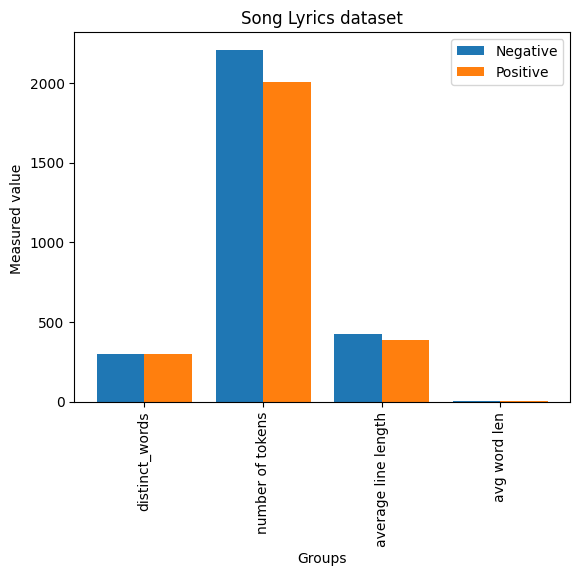

In [64]:
from collections import Counter

distinct_words_neg, len_toks_neg, avg_line_len_neg, avg_word_len_neg = metrics(negdf)

distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos = metrics(posdf)

# number of distinct words in alyric
# average number of tokens in a lyric
print("distinct_words : ", "average number of tokens : ", "avg_line_length : ", "avg_word_len" )
print(distinct_words_neg, len_toks_neg, avg_line_len_neg, avg_word_len_neg)
print(distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos)

X = ['distinct_words', 'number of tokens', 'average line length', "avg word len"]
Y_neg = [distinct_words_neg, len_toks_neg,  avg_line_len_neg, avg_word_len_neg]
Z_pos = [distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y_neg, 0.4, label = 'Negative')
plt.bar(X_axis + 0.2, Z_pos, 0.4, label = 'Positive')

plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Measured value ")
plt.title("Song Lyrics dataset")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

### Song generation and similarity scores

In [65]:
# data frame of generated positive and negative songs
gen_pos_df = pd.DataFrame(positive_songs, columns = ['Lyrics'])
gen_neg_df = pd.DataFrame(negative_songs, columns = ['Lyrics'])

In [66]:
def gen_metrics(text):
    #number of distinct words in a lyric
    counter = Counter(text['Lyrics'])
    distinct_words = len(counter)

    #average number of tokens in a lyric
    len_toks = sum(text['Lyrics'].str.len())/len(text['Lyrics'])


    #average line length
    subset = text
    songs = list(subset[subset['Lyrics'].notnull()]['Lyrics'].str.split(pat = "\n"))#songs

    song_line_len = []
    for song in songs:
        line_lens = []
        for line in song:
            line_lens.append(len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_line_len = sum(song_line_len)/len(songs)


    #average word length
    song_line_len = []
    for song in songs:
        line_lens = []
        for line in song:
            line_lens.append(len(line)/len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_word_len = sum(song_line_len)/len(songs)


    return distinct_words, len_toks, avg_line_len, avg_word_len

distinct_words :  average number of tokens :  avg_word_length :   avg_word_length:
10 1230.8 6.284018127156896 2.7679090188514417
10 1218.7 6.7305984510444405 2.7811732937757028


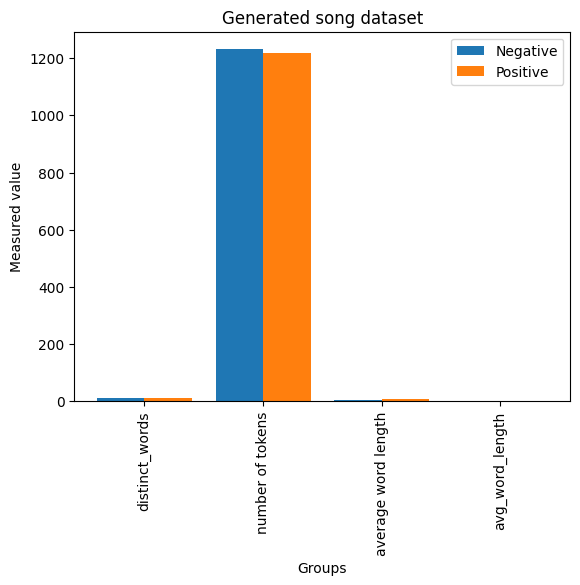

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

distinct_words_neg, len_toks_neg, avg_line_len_neg,avg_word_len_neg  = gen_metrics(gen_neg_df)

distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos = gen_metrics(gen_pos_df)

# number of distinct words in alyric
# average number of tokens in a lyric
print("distinct_words : ", "average number of tokens : ", "avg_word_length : ", " avg_word_length:")
print(distinct_words_neg, len_toks_neg, avg_line_len_neg, avg_word_len_neg)
print(distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos)

X = ['distinct_words', 'number of tokens', 'average word length', "avg_word_length"]
Y_neg = [distinct_words_neg, len_toks_neg,  avg_line_len_neg, avg_word_len_neg]
Z_pos = [distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y_neg, 0.4, label = 'Negative')
plt.bar(X_axis + 0.2, Z_pos, 0.4, label = 'Positive')

plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Measured value")
plt.title("Generated song dataset")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [68]:
## measuring SPacy similarity b/n ten random songs (from each positive and negative dataset) vs generated songs (pos and neg)

def get_random_songs(dataset, num):
    songs = []
    for i in range(num):

        # song = dataset['Lyrics'].sample(n=num)
        song = dataset['Lyrics'].sample().values[0]
        songs.append(song)

    return songs

# list of string of all songs
pos_songs_df = get_random_songs(posdf, 10)
neg_songs_df = get_random_songs(negdf, 10)

In [69]:
# instruction : sudo pip3 install spacy
# instruction : sudo python3 -m spacy download en
import spacy
nlp = spacy.load('en_core_web_sm')

In [70]:
# positive songs cosine similarity
pos_sim = 0
pos_songs_dataset = [x for [x] in positive_songs]

for ds, gen in zip(pos_songs_dataset, pos_songs_df):
    pos_sim = pos_sim + nlp(ds).similarity(nlp(gen))

avg_pos_cos_sim = pos_sim / 10
print("AVERAGE POSITIVE COSINE SIMILARITY : ",avg_pos_cos_sim)


<ipython-input-70-d8e59c1ca1b8>:6: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  pos_sim = pos_sim + nlp(ds).similarity(nlp(gen))


AVERAGE POSITIVE COSINE SIMILARITY :  0.7251916284454906


In [71]:
# Negative songs cosine similarity
neg_sim = 0
# flatten
neg_songs_dataset = [x for [x] in negative_songs]

for ds, gen in zip(neg_songs_dataset, neg_songs_df):

    neg_sim = neg_sim + nlp(ds).similarity(nlp(gen))

avg_neg_cos_sim = neg_sim / 10
print("AVERAGE NEGATIVE COSINE SIMILARITY : ",avg_neg_cos_sim)

<ipython-input-71-7907a773cfd5>:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  neg_sim = neg_sim + nlp(ds).similarity(nlp(gen))


AVERAGE NEGATIVE COSINE SIMILARITY :  0.7057735946610217


## GRAPH COSINE SIMILARITY


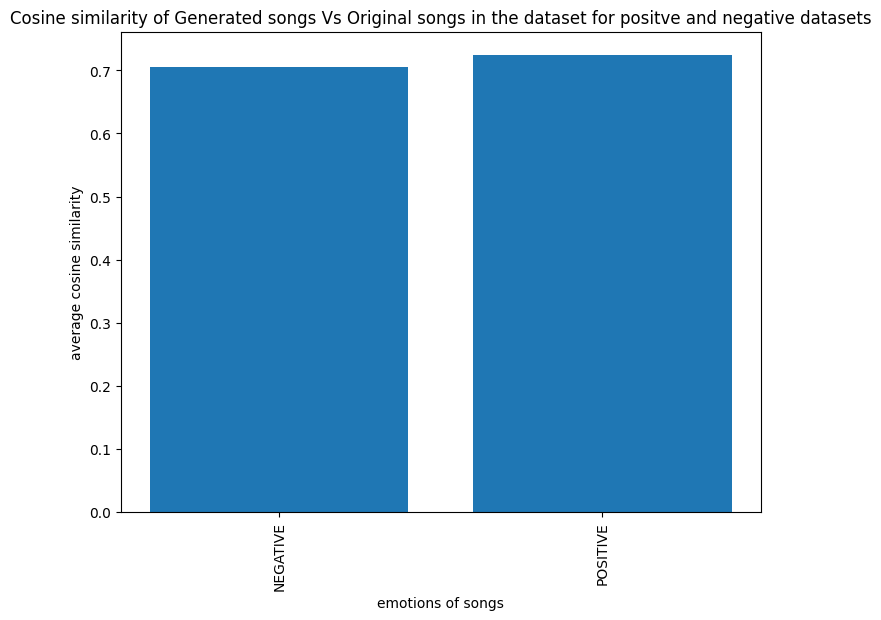

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dataset = ['NEGATIVE', 'POSITIVE']
sim_val = [avg_neg_cos_sim, avg_pos_cos_sim]
plt.xlabel("emotions of songs")
plt.ylabel("average cosine similarity")
plt.title("Cosine similarity of Generated songs Vs Original songs in the dataset for positve and negative datasets")
plt.xticks(rotation = 90)
ax.bar(dataset,sim_val)
plt.show()